<a href="https://colab.research.google.com/github/genaiconference/RAG_Workshop_DHS2024/blob/main/12_agentic_rag_finance_copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

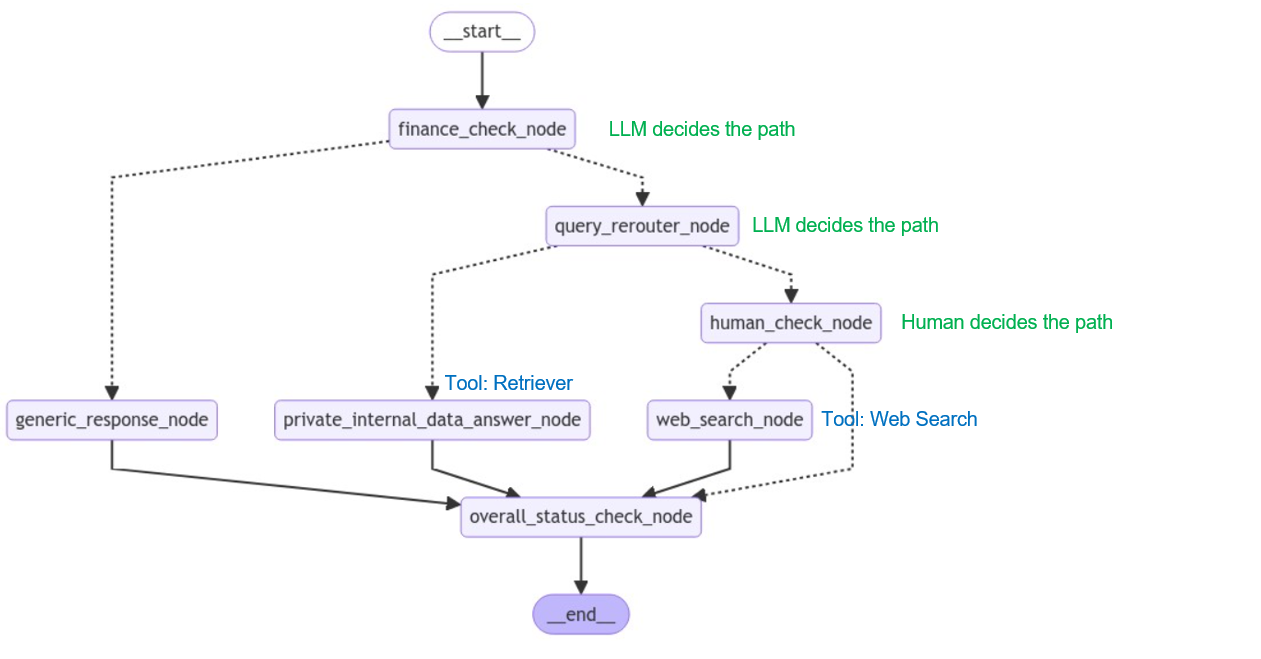

# Traditional RAG Workflow

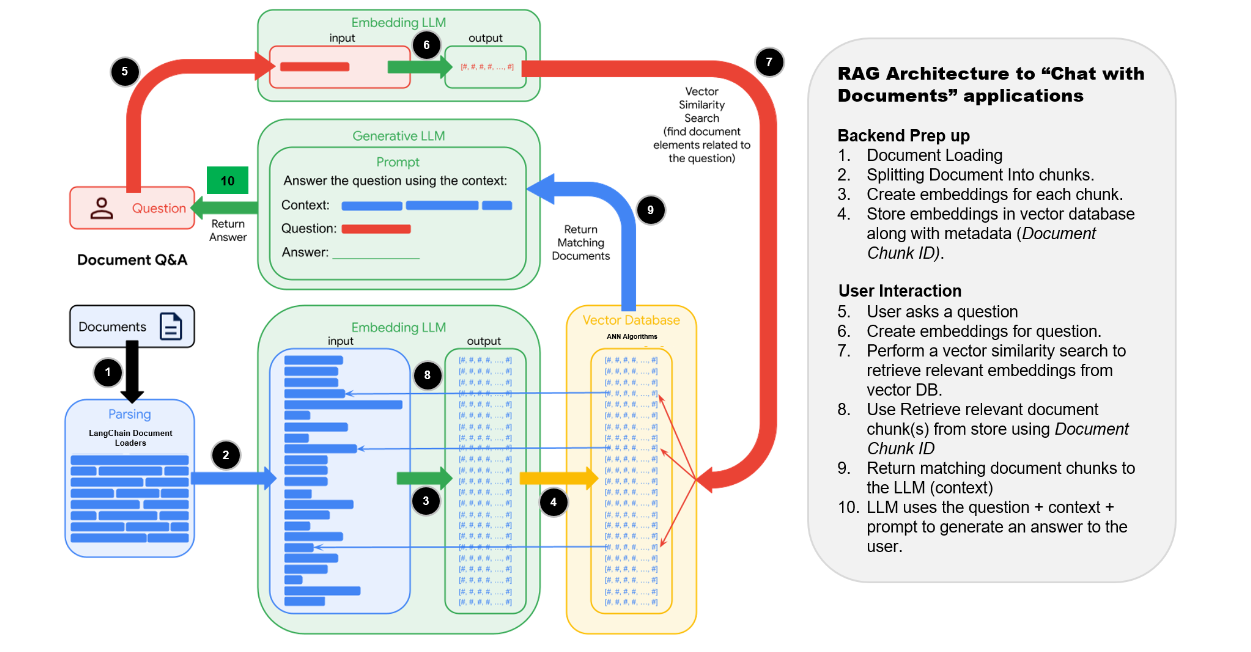

In [1]:
!git clone https://github.com/genaiconference/RAG_Workshop_DHS2024.git

Cloning into 'RAG_Workshop_DHS2024'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 131 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 30.90 MiB | 7.41 MiB/s, done.
Resolving deltas: 100% (56/56), done.
Updating files: 100% (34/34), done.


In [2]:
!pip install -q langchain==0.2.9 langchain-openai==0.1.7 langchain-chroma==0.1.2 langgraph==0.0.55 beautifulsoup4==4.12.2 tavily-python==0.3.5 python_dotenv==1.0.1 langchain-experimental==0.0.62 simple-colors==0.1.5 pypdf==3.16.2 rank_bm25==0.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.7/202.7 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s et

#### Load environment variables

In [4]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv(dotenv_path="/content/.env")

llm  = ChatOpenAI(model="gpt-4o")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## 1. Define tools for agents

### Create tools to retrieve the content from the private data sources

**List of Private Data Sources**
* Leave Policy Documents
* Company Annual Reports

**Public Data Sources**
* Tavily Web Search Tool


Create a Retriever for Internal Leave Policy Documents

In [6]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = PyPDFLoader('/content/RAG_Workshop_DHS2024/data/misc/Leave-Policy-India.pdf')
documents = loader.load()

print(len(documents))

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)
splits = text_splitter.split_documents(documents)
print(len(splits))

from langchain.vectorstores import Chroma
persist_directory = os.getcwd() +'/vectorstore/leave_policy/'
# Create the vector store
vectordb = Chroma.from_documents(documents=splits, embedding=embeddings, persist_directory=persist_directory )
print(vectordb._collection.count())

retriever = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 3})

8
10
10


Create a Retriever for Internal Company Annual Reports

In [7]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader

loader = PyPDFLoader('/content/RAG_Workshop_DHS2024/data/misc/microsoft_annual_report_2022.pdf')
documents = loader.load()
print(len(documents))

from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)

docs = text_splitter.split_documents(documents)

print(len(docs))


## save to disk
vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory='vectorstore/annual_reports/')

from langchain.retrievers import MergerRetriever, BM25Retriever

# Define 2 diff retrievers with 2 diff search type.
retriever_1 = vectorstore.as_retriever(search_type="similarity",
                                                 search_kwargs={"k": 5}
                                                )

retriever_2 = vectorstore.as_retriever(search_type="mmr",
                                                 search_kwargs={"k": 5}
                                                )

# BM25 Retriver for keyword based retrieval using BM25 algorithm
bm25_retriever = BM25Retriever.from_documents(docs)

bm25_retriever.k = 3 # set the num of docs to be retrieved

# Hybrid Retriver using Semantic Search and Keyword search together
lotr_annual_reports = MergerRetriever(retrievers=[retriever_1, retriever_2, bm25_retriever])

93
128


### Creating Retrivers as tools

In [9]:
from langchain.tools.retriever import create_retriever_tool

leave_policy_tool = create_retriever_tool(retriever=retriever,
                                              name = 'Leave_Policy_Data_Tool',
                                              description="Use this tool to answer questions related to the leave policies of the company")


annual_reports_tool = create_retriever_tool(retriever=lotr_annual_reports,
                                              name = 'Annual_Reports_Data_Tool',
                                              description="Use this tool to answer questions related to the annual reports of Microsoft")

Inside any retriever or web search API as a tool

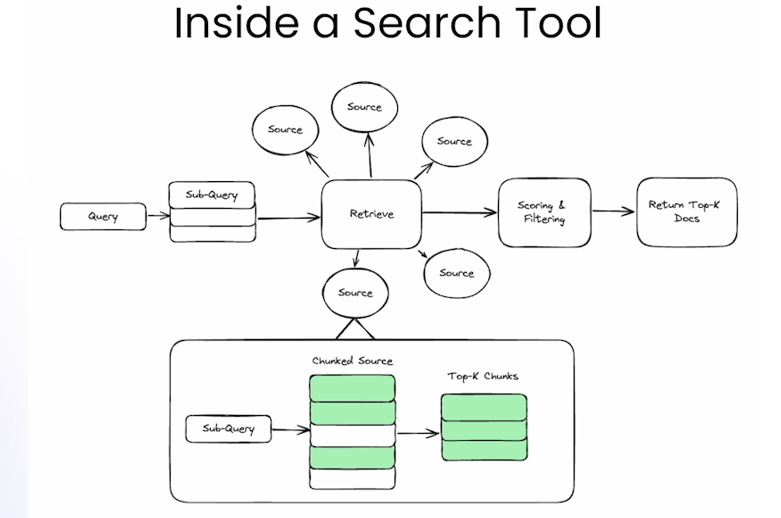

### Web Search Tool - Internet search and content processing


In [10]:
import json
import requests
from bs4 import BeautifulSoup
from langchain.tools import tool
from langchain_community.utilities import BingSearchAPIWrapper
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever

from RAG_Workshop_DHS2024.prompts import *
from RAG_Workshop_DHS2024.copilot_utils import create_qa_agent, create_chat_agent

# Create a tool to processes content from a webpage
@tool("process_content", return_direct=False)
def process_content(url: str, chunk_size: int = 10000) -> str:
    """
    Use this tool to extract content from HTML pages and chunk it recursively.

    Args:
      url (str): The URL of the HTML page to process.
      chunk_size (int, optional): The maximum size of each text chunk. Defaults to 100000.

    Returns:
      str: The chunked text content extracted from the HTML page.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser',from_encoding="iso-8859-1")
    text = soup.get_text()

    def chunk_text(text, chunk_size):
        if len(text) <= chunk_size:
            return text
        else:
            midpoint = len(text) // 2
            left_chunk = chunk_text(text[:midpoint], chunk_size)
            right_chunk = chunk_text(text[midpoint:], chunk_size)
            return left_chunk + "\n" + right_chunk

        chunks = chunk_text(text, chunk_size)
        return chunks


@tool("bing_search", return_direct=False)
def bing_search(query: str) -> str:
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    bing_search = BingSearchAPIWrapper()
    results = bing_search.results(query, 5)
    return results if results else "No results found."


# Create a tool to search the internet using TavilySearchAPI - Alternative to Bing Search
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool


# **Now Let's understand the step by step creation of a Graph**

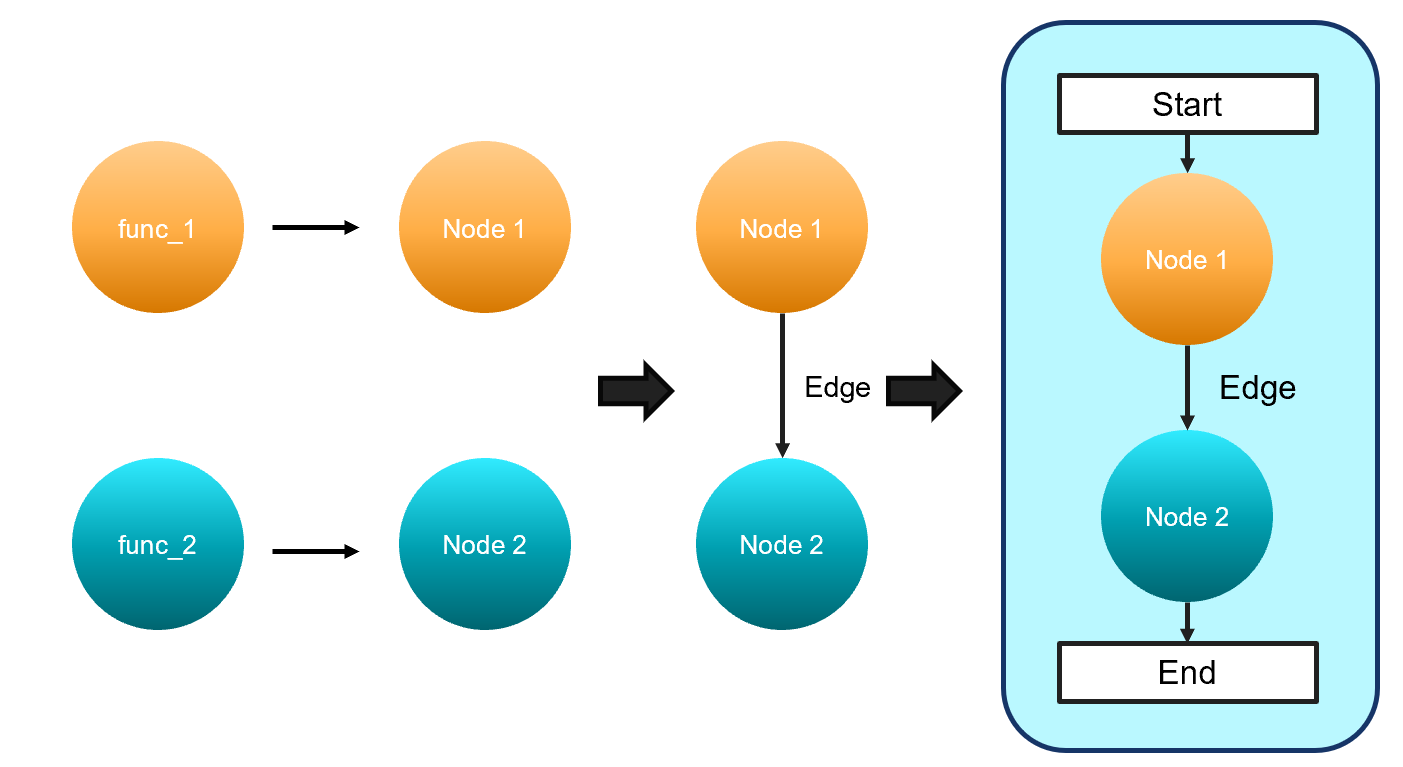

#### Define the functions to later convert them as Graph Nodes

In [11]:
import warnings
warnings.filterwarnings("ignore")

from simple_colors import *
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from IPython.display import Markdown
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.output_parsers import JsonOutputParser



class FinanceCheck_class(BaseModel):
    """Binary score for finance check on the user question."""
    binary_score: str = Field(description="Given a user question, return 'Yes' if is related to Finance/Accounting/Reporting else 'No'")


def get_finance_check(_llm, META_RESPONSE_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=FinanceCheck_class)
    prompt = PromptTemplate(template=META_RESPONSE_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},)
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    result = parser.invoke(output)
    return result.binary_score


def finance_check_node(state):
    """Use this tool to check whether the user question is about finance or general greeting."""
    observation = get_finance_check(llm, META_RESPONSE_PROMPT_DETAILED, state['question'])

    print("------ENTERING: FINANCE CHECK NODE------")
    print(f"------OBSERVATION: {observation}------")

    return {"finance_check": observation}


def generic_response_node(state):
    """Use this tool to answer user generic questions"""
    print("------ENTERING: GENERIC RESPONSE NODE------")

    answer = llm.invoke(META_ANSWER_PROMPT.format(question=question))
    final_answer = answer.content
    display(Markdown(f"""<font color="black">**GENERIC RESPONSE:**</font>"""))
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"generic_response": answer, "final_answer": final_answer}


class RouteQuery_class(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["FINANCE", "WEB"] = Field(description="Given a user question choose to route it to WEB or FRA.")

def get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT, state):
    parser = PydanticOutputParser(pydantic_object=RouteQuery_class)

    prompt = PromptTemplate(template=QUERY_REROUTER_PROMPT,
                            input_variables=["question"],
                            partial_variables={"format_instructions": parser.get_format_instructions()},
                           )
    prompt_and_model = prompt | llm

    output = prompt_and_model.invoke({"question": question})
    query_rerouter_check = parser.invoke(output)

    return query_rerouter_check.datasource

def query_rerouter_node(state):
    """Use this tool to check whether the user question needs an internet search to answer"""
    print("------ENTERING: QUERY REROUTER NODE------")
    observation = get_query_rerouter_check(llm, QUERY_REROUTER_PROMPT_DETAILED, state['question'])

    print(f"------OBSERVATION: {observation}------")
    return {"query_rerouter_check": observation}

def human_check_node(state):
    user_input = input("The answer is not available from the private data sources! Do you want me to search over the internet to answer?")
    return {"human_response": user_input.lower()}

def get_web_search_answer(state):
    internet_search_tool = get_tavily_search_retriever()
    # tools = [bing_search, process_content]
    tools = [internet_search_tool, process_content]

    generate_prompt = """You are a web searcher trained to retrieve the current events from the internet. Search the internet for information.
                            Generate the best answer possible for the user's request with mandatory mention of the sources and the hyperlinks for the sources wherever it is possible.
                            Think step by step. Breakdown the question if it has multiple asks and finally merge your results.
                            Always crave for the best version of answer.
                            - **Always** before giving the final answer, try another method.Then reflect on the answers of the two methods you did and ask yourself if it answers correctly the original question. If you are not sure, try another method.
                            - If the methods tried do not give the same result, reflect and try again until you have two methods that have the same result.
                            - If you are sure of the correct answer, create a beautiful and thorough response.
                            ** DO NOT MAKE UP AN ANSWER OR USE YOUR PRIOR KNOWLEDGE, ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE **
                            PLEASE NOTE THAT IF NO SPECIFIC YEAR MENTIONED IN THE QUESTION, ALWAYS LOOK FOR THE LATEST YEAR.
                            """

    generate_agent = create_qa_agent(llm, tools, generate_prompt, verbose=False)
    answer = generate_agent.invoke({"input": state['question']})
    return answer['output']


def web_search_node(state):
    """Use this tool when you need to answer questions related to current events and latest happenings"""
    print("------ENTERING: WEB SEARCH NODE------")
    ## Write code here to get answer
    response = get_web_search_answer(state)
    print(f"------WEB SEARCH ANSWER: {response}------")
    display(Markdown(f"""<font color="Black">**WEB ANSWER:**</font>"""))
    display(Markdown(f"""<font color="green">{response}</font>"""))

    return {"web_response": response, "final_answer": response}


def private_internal_data_answer_node(state):
    """Use this tool to answer any questions related to leave policies of the compny"""
    print("------ENTERING: PRIVATE INTERNAL DATA ANSWER NODE------")

    tools = [leave_policy_tool, annual_reports_tool]
    generate_agent = create_qa_agent(llm, tools, private_internal_data_prompt, verbose=False)
    answer = generate_agent.invoke({"input": state['question']})
    final_answer = f"""**PRIVATE INTERNAL DATA ANSWER:** {answer['output']} \n\n"""
    display(Markdown(f"""<font color="green">{final_answer}</font>"""))
    return {"private_internal_data_response": answer['output'], 'final_answer':final_answer}


def overall_status_check_node(state):
    """Use this tool to check the overall status and update the config settings"""
    print("------ENTERING: OVERALL STATUS CHECK NODE------")
    final_answer = state['final_answer']
    observation = "Completed"
    print("-------------------------------- {} --------------------------------".format(black("Final Answer", ['bold'])))
    display(Markdown(f"""**FINAL ANSWER:**\n\n <font color="green">{final_answer}</font>"""))

    return {"overall_status_check": observation, 'final_answer':final_answer}

# **Define the Graph State**

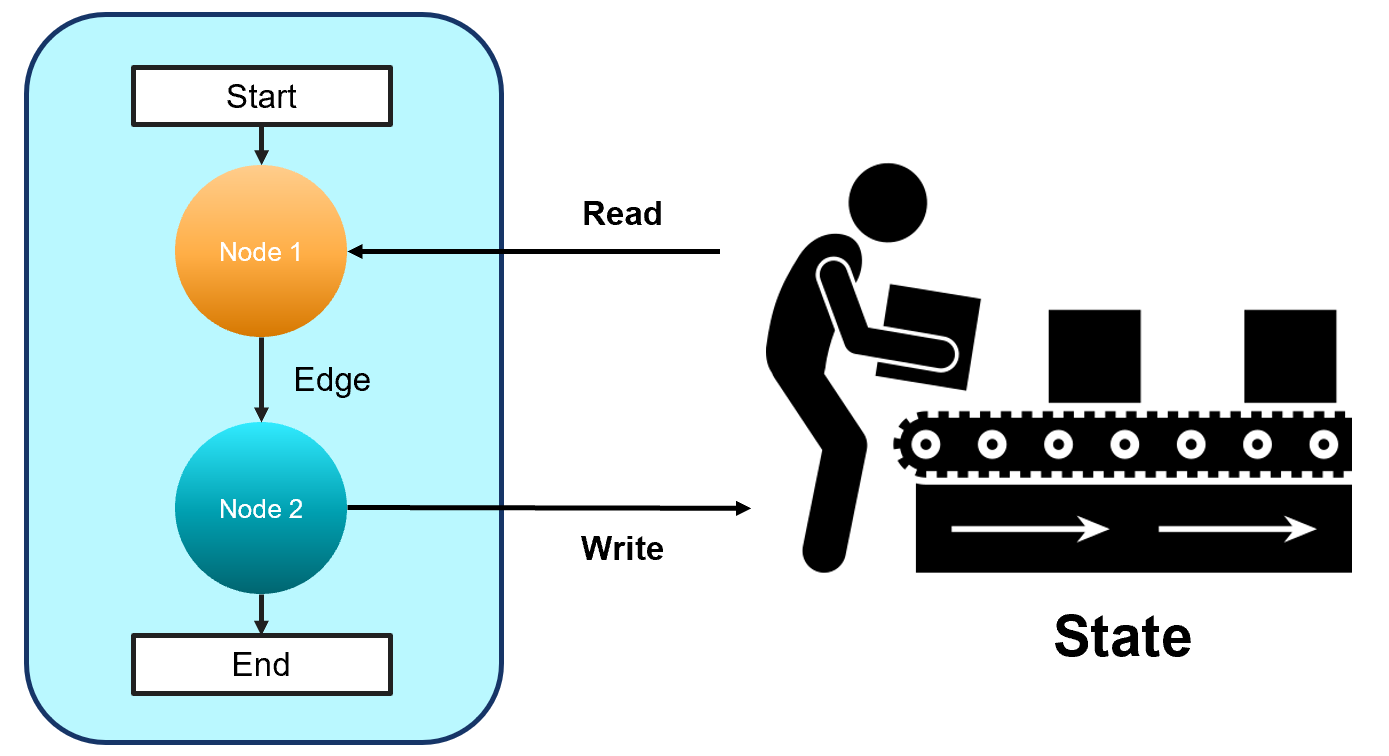

In [12]:
from typing_extensions import TypedDict
from typing import Annotated, List
import operator


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
      question: User Question

      finance_check: Whether the user question is about finance or generic question
      query_rerouter_check: Check to assess the questions needs internal private data sources or seb search to answer
      source_detector_check: Check to assess what internal private sources to be needed to answer user question
      overall_status_check: Check to assess the overall graph completion

      generic_response: Generic answer
      human_response: Human response to search over internet
      web_response: Web search response
      private_internal_data_response: IFRS Response
      final_answer: Final Answer
    """

    question: str

    finance_check: str
    query_rerouter_check: str
    source_detector_check: List[str]
    overall_status_check: str

    generic_response: str
    human_response: str
    web_response: str
    private_internal_data_response: str
    final_answer: Annotated[str, operator.add]

# **Now construct the Graph architecture**

### First add all the nodes to the Graph

In [13]:
from langgraph.graph import StateGraph

builder = StateGraph(GraphState)
builder.add_node("finance_check_node", finance_check_node)
builder.add_node("generic_response_node", generic_response_node)
builder.add_node("query_rerouter_node", query_rerouter_node)
builder.add_node("human_check_node", human_check_node)
builder.add_node("web_search_node", web_search_node)
builder.add_node("private_internal_data_answer_node", private_internal_data_answer_node)
builder.add_node("overall_status_check_node", overall_status_check_node)

### Now define the workflow

In [14]:
from langgraph.checkpoint.sqlite import SqliteSaver

builder.set_entry_point("finance_check_node")

def finance_check_edge(state):
    if state["finance_check"] == "Yes":
        print("------DECISION: INVOKE QUERY REROUTER NODE------")
        return "query_rerouter_node"
    else:
        print("------DECISION: INVOKE GENERIC RESPONSE NODE------")
        return "generic_response_node"


finance_check_possible_nodes = ["query_rerouter_node", "generic_response_node"]
builder.add_conditional_edges("finance_check_node", finance_check_edge, finance_check_possible_nodes)
builder.add_edge("generic_response_node", "overall_status_check_node")


def query_rerouter_edge(state):
    if state["query_rerouter_check"] == "FINANCE":
        print("------DECISION: INVOKE SOURCE DETECTOR NODE------")
        return "private_internal_data_answer_node"
    else:
        print("------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------")
        return "human_check_node"


query_rerouter_possible_nodes = ["human_check_node", "private_internal_data_answer_node"]
builder.add_conditional_edges("query_rerouter_node", query_rerouter_edge, query_rerouter_possible_nodes)


def human_check_edge(state):
    if state['human_response'] == "yes":
        print("------DECISION: INVOKE WEB SEARCH NODE------")
        return "web_search_node"
    else:
        print("------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------")
        return "overall_status_check_node"


builder.add_conditional_edges("human_check_node", human_check_edge, ["web_search_node", "overall_status_check_node"])

builder.add_edge("web_search_node", "overall_status_check_node")

builder.add_edge("private_internal_data_answer_node", "overall_status_check_node")

builder.set_finish_point("overall_status_check_node")

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

### Let's visualize the Graph

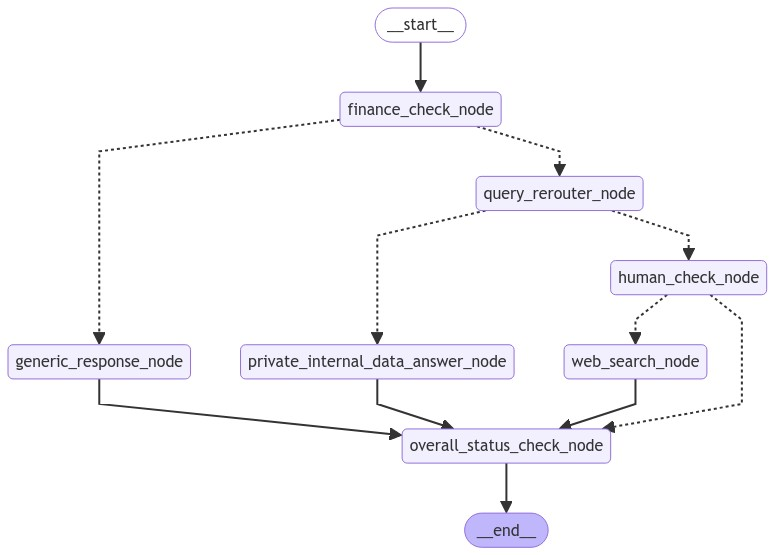

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Let's ask the questions now!

Thread ID helps in setting the memory thread

In [16]:
def run_graph(question, thread_id):
    inputs = {"question": question}
    thread = {"configurable": {"thread_id": str(thread_id)}}
    for output in graph.stream(inputs, thread, stream_mode='values'):
        pass

In [17]:
question = "Who are you?"
run_graph(question, 89)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: No------
------DECISION: INVOKE GENERIC RESPONSE NODE------
------ENTERING: GENERIC RESPONSE NODE------


<font color="black">**GENERIC RESPONSE:**</font>

<font color="green">Hello! I am Finance Copilot. I am a Generative AI powered buddy here to assist finance professionals with a wide range of technical accounting and financial process challenges. If you have any finance-related questions or need insights based on accounting standards and reports, feel free to ask!</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">Hello! I am Finance Copilot. I am a Generative AI powered buddy here to assist finance professionals with a wide range of technical accounting and financial process challenges. If you have any finance-related questions or need insights based on accounting standards and reports, feel free to ask!</font>

In [18]:
question = "What is the income of Dr Reddys Labs in 2024 Q1?"
run_graph(question,9)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: WEB------
------DECISION: CHECK WITH USER TO INVOKE WEB SEARCH NODE------
The answer is not available from the private data sources! Do you want me to search over the internet to answer?No
------Your question cannot be answered due to lack of information from private data sources, please ask a different question!------
------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green"></font>

In [19]:
question = "How many leaves that I can avail as part of parental leave policy?"
run_graph(question, 99)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: No------
------DECISION: INVOKE GENERIC RESPONSE NODE------
------ENTERING: GENERIC RESPONSE NODE------


<font color="black">**GENERIC RESPONSE:**</font>

<font color="green">I would be happy to help with your finance-related queries. Unfortunately, I don't have access to information on parental leave policies. Please feel free to ask me any questions related to financial processes or accounting standards.</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">I would be happy to help with your finance-related queries. Unfortunately, I don't have access to information on parental leave policies. Please feel free to ask me any questions related to financial processes or accounting standards.</font>

In [20]:
question = "How many times i can avail parental leave policy"
run_graph(question, 92)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: No------
------DECISION: INVOKE GENERIC RESPONSE NODE------
------ENTERING: GENERIC RESPONSE NODE------


<font color="black">**GENERIC RESPONSE:**</font>

<font color="green">I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!</font>

In [22]:
question = "List down all the microsoft products and the corresponding profits for the yesr 2023"
run_graph(question, 92)

------ENTERING: FINANCE CHECK NODE------
------OBSERVATION: Yes------
------DECISION: INVOKE QUERY REROUTER NODE------
------ENTERING: QUERY REROUTER NODE------
------OBSERVATION: FINANCE------
------DECISION: INVOKE SOURCE DETECTOR NODE------
------ENTERING: PRIVATE INTERNAL DATA ANSWER NODE------


<font color="green">**PRIVATE INTERNAL DATA ANSWER:** As per IFRS standards, the detailed financial data for Microsoft's products and corresponding profits for the year 2023 is not provided in the context. However, the revenue for various segments for the fiscal year 2022 compared with fiscal year 2021 is given:

1. **Productivity and Business Processes**
   - Revenue: $63,364 million (2022) vs. $53,915 million (2021)
   - Increase: 18%

2. **Intelligent Cloud**
   - Revenue: $75,251 million (2022) vs. $60,080 million (2021)
   - Increase: 25%

3. **More Personal Computing**
   - Revenue: $59,655 million (2022) vs. $54,093 million (2021)
   - Increase: 10%

For detailed product-specific profit data for 2023, the exact figures are not available in the provided context.

(Citation: Annual_Reports_Data_Tool, page 34) 

</font>

------ENTERING: OVERALL STATUS CHECK NODE------
-------------------------------- Final Answer --------------------------------


**FINAL ANSWER:**

 <font color="green">I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!**PRIVATE INTERNAL DATA ANSWER:** ### Microsoft Products Based on Profits:

#### Productivity and Business Processes:
1. **Office Commercial**:
   - Office 365 subscriptions
   - Office 365 portion of Microsoft 365 Commercial subscriptions
   - Office licensed on-premises (Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva)
   - Revenue increased by $4.4 billion or 13% ([Annual Report, p. 35](#)).
   
2. **Office Consumer**:
   - Microsoft 365 Consumer subscriptions
   - Office licensed on-premises
   - Other Office services
   - Revenue increased by $641 million or 11% ([Annual Report, p. 35](#)).

3. **LinkedIn**:
   - Talent Solutions, Marketing Solutions, Premium Subscriptions, Sales Solutions
   - Revenue increased by $3.5 billion or 34% ([Annual Report, p. 35](#)).

4. **Dynamics**:
   - Dynamics 365 (ERP, CRM, Customer Insights, Power Apps, Power Automate)
   - On-premises ERP and CRM applications
   - Revenue increased by 25% driven by Dynamics 365 growth of 39% ([Annual Report, p. 35](#)).

#### Intelligent Cloud:
1. **Azure and other cloud services**:
   - Revenue from Azure increased by 45%
   - Server products: SQL Server, Windows Server, Visual Studio, System Center, related Client Access Licenses (CALs), Nuance, GitHub
   - Revenue increased by $14.7 billion or 28% ([Annual Report, p. 35](#)).

2. **Enterprise Services**:
   - Enterprise Support Services, Microsoft Consulting Services, Nuance professional services
   - Revenue increased by $464 million or 7% ([Annual Report, p. 35](#)).

#### More Personal Computing:
1. **Windows**:
   - Windows OEM licensing
   - Other non-volume licensing of the Windows OS
   - Windows Commercial: volume licensing, Windows cloud services, Windows IoT
   - Revenue increased by $2.3 billion or 10% ([Annual Report, p. 35](#)).

2. **Devices**:
   - Surface and PC accessories
   - Surface revenue increased by 3% ([Annual Report, p. 30](#)).

3. **Gaming**:
   - Xbox hardware and Xbox content and services
   - Xbox Game Pass, Xbox Cloud Gaming, third-party disc royalties, advertising, other cloud services
   - Xbox content and services revenue increased by 3% ([Annual Report, p. 30](#)).

4. **Search and News Advertising**:
   - Revenue excluding traffic acquisition costs increased by 27% ([Annual Report, p. 30](#)).

These are the main product categories of Microsoft, listed based on their reported profits and revenue growth. 

I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!I would be happy to assist you with your finance-related queries. Please provide me with a question related to financial processes, technical accounting, or similar topics. Thank you!**PRIVATE INTERNAL DATA ANSWER:** ### Microsoft Products Based on Profits:

#### Productivity and Business Processes:
1. **Office Commercial**:
   - Office 365 subscriptions
   - Office 365 portion of Microsoft 365 Commercial subscriptions
   - Office licensed on-premises (Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva)
   - Revenue increased by $4.4 billion or 13% ([Annual Report, p. 35](#)).
   
2. **Office Consumer**:
   - Microsoft 365 Consumer subscriptions
   - Office licensed on-premises
   - Other Office services
   - Revenue increased by $641 million or 11% ([Annual Report, p. 35](#)).

3. **LinkedIn**:
   - Talent Solutions, Marketing Solutions, Premium Subscriptions, Sales Solutions
   - Revenue increased by $3.5 billion or 34% ([Annual Report, p. 35](#)).

4. **Dynamics**:
   - Dynamics 365 (ERP, CRM, Customer Insights, Power Apps, Power Automate)
   - On-premises ERP and CRM applications
   - Revenue increased by 25% driven by Dynamics 365 growth of 39% ([Annual Report, p. 35](#)).

#### Intelligent Cloud:
1. **Azure and other cloud services**:
   - Revenue from Azure increased by 45%
   - Server products: SQL Server, Windows Server, Visual Studio, System Center, related Client Access Licenses (CALs), Nuance, GitHub
   - Revenue increased by $14.7 billion or 28% ([Annual Report, p. 35](#)).

2. **Enterprise Services**:
   - Enterprise Support Services, Microsoft Consulting Services, Nuance professional services
   - Revenue increased by $464 million or 7% ([Annual Report, p. 35](#)).

#### More Personal Computing:
1. **Windows**:
   - Windows OEM licensing
   - Other non-volume licensing of the Windows OS
   - Windows Commercial: volume licensing, Windows cloud services, Windows IoT
   - Revenue increased by $2.3 billion or 10% ([Annual Report, p. 35](#)).

2. **Devices**:
   - Surface and PC accessories
   - Surface revenue increased by 3% ([Annual Report, p. 30](#)).

3. **Gaming**:
   - Xbox hardware and Xbox content and services
   - Xbox Game Pass, Xbox Cloud Gaming, third-party disc royalties, advertising, other cloud services
   - Xbox content and services revenue increased by 3% ([Annual Report, p. 30](#)).

4. **Search and News Advertising**:
   - Revenue excluding traffic acquisition costs increased by 27% ([Annual Report, p. 30](#)).

These are the main product categories of Microsoft, listed based on their reported profits and revenue growth. 

**PRIVATE INTERNAL DATA ANSWER:** As per IFRS standards, the detailed financial data for Microsoft's products and corresponding profits for the year 2023 is not provided in the context. However, the revenue for various segments for the fiscal year 2022 compared with fiscal year 2021 is given:

1. **Productivity and Business Processes**
   - Revenue: $63,364 million (2022) vs. $53,915 million (2021)
   - Increase: 18%

2. **Intelligent Cloud**
   - Revenue: $75,251 million (2022) vs. $60,080 million (2021)
   - Increase: 25%

3. **More Personal Computing**
   - Revenue: $59,655 million (2022) vs. $54,093 million (2021)
   - Increase: 10%

For detailed product-specific profit data for 2023, the exact figures are not available in the provided context.

(Citation: Annual_Reports_Data_Tool, page 34) 

</font>